# Demo - Bias in Word Embedding

In this demo, we are going to work with three complete word embeddings at once in the notebook, which will take a lot of memory (~20GB). Therefore, if your machine doesn't have plenty of RAM, it is possible to perform the analysis either separately for each word embeddings or only on one.

## Imports

In [1]:
import matplotlib.pylab as plt

from gensim import downloader
from gensim.models import KeyedVectors

## Download and Load Word Embeddings

### [Google's Word2Vec](https://code.google.com/archive/p/word2vec/) - Google News dataset (100B tokens, 3M vocab, cased, 300d vectors, 1.65GB download)

In [2]:
w2v_path = downloader.load('word2vec-google-news-300', return_path=True)
print(w2v_path)

w2v_model = KeyedVectors.load_word2vec_format(w2v_path, binary=True)

/home/users/shlohod/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


### [Facebook's fastText](https://fasttext.cc/)

In [3]:
fasttext_path = downloader.load('fasttext-wiki-news-subwords-300', return_path=True)
print(fasttext_path)

fasttext_model = KeyedVectors.load_word2vec_format(fasttext_path)

/home/users/shlohod/gensim-data/fasttext-wiki-news-subwords-300/fasttext-wiki-news-subwords-300.gz


### [Stanford's Glove](https://nlp.stanford.edu/projects/glove/) - Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download)

In [4]:
import os
import gzip
import shutil
from urllib.request import urlretrieve
from zipfile import ZipFile
from pathlib import Path

from gensim.scripts.glove2word2vec import glove2word2vec

GLOVE_PATH = None

if GLOVE_PATH is None:
    print('Downloading...')
    glove_zip_path, _ = urlretrieve('http://nlp.stanford.edu/data/glove.840B.300d.zip')
    glob_dir_path = Path(glove_zip_path).parent
    print('Unzipping...')
    with ZipFile(glove_zip_path, 'r') as zip_ref:
        zip_ref.extractall(str(glob_dir_path))
    print('Converting to Word2Vec format...')
    glove2word2vec(glob_dir_path / 'glove.840B.300d.txt',
                   glob_dir_path / 'glove.840B.300d.w2v.txt')

print('Loading...')    
glove_model = KeyedVectors.load_word2vec_format(glob_dir_path / 'glove.840B.300d.w2v.txt')

Downloading...
Unzipping...
Converting to Word2Vec format...
Loading...


## Bolukbasi Bias Measure and Debiasing

Based on:
Bolukbasi Tolga, Kai-Wei Chang, James Y. Zou, Venkatesh Saligrama, and Adam T. Kalai. [Man is to computer programmer as woman is to homemaker? debiasing word embeddings](https://arxiv.org/abs/1607.06520). NIPS 2016.

In [5]:
from responsibly.we import GenderBiasWE, most_similar

### Create a gender bias word embedding object (`GenderBiasWE`)

In [6]:
w2v_gender_bias_we = GenderBiasWE(w2v_model, only_lower=False, verbose=True)

Identify direction using pca method...
  Principal Component    Explained Variance Ratio
---------------------  --------------------------
                    1                  0.605292
                    2                  0.127255
                    3                  0.099281
                    4                  0.0483466
                    5                  0.0406355
                    6                  0.0252729
                    7                  0.0232224
                    8                  0.0123879
                    9                  0.00996098
                   10                  0.00834613


### Evaluate the Word Embedding

In [7]:
w2v_biased_evaluation = w2v_gender_bias_we.evaluate_word_embedding()

#### Word pairs

In [8]:
w2v_biased_evaluation[0]

,pearson_r,pearson_pvalue,spearman_r,spearman_pvalue,ratio_unkonwn_words
MEN,0.682,0.00,0.699,0.00,0.000
Mturk,0.632,0.00,0.656,0.00,0.000
RG65,0.801,0.03,0.685,0.09,0.000
RW,0.523,0.00,0.553,0.00,33.727
SimLex999,0.447,0.00,0.436,0.00,0.100
TR9856,0.661,0.00,0.662,0.00,85.430
WS353,0.624,0.00,0.659,0.00,0.000


#### Analogies

In [9]:
w2v_biased_evaluation[1]

,score
Google,0.740
MSR-syntax,0.736


### Calculate direct gender bias

In [10]:
w2v_gender_bias_we.calc_direct_bias()

0.07307904523121492

### Plot the projection of the most extreme professions on the gender direction

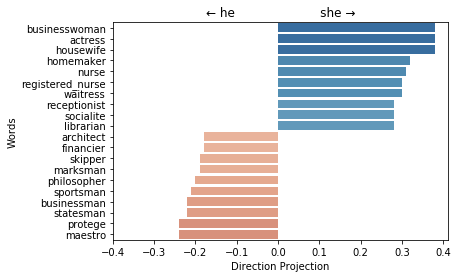

In [11]:
w2v_gender_bias_we.plot_projection_scores();

### Plot the distribution of projections of the word groups that are being used for the auditing and adjusting the model

1. **profession_name** - List of profession names, neutral and gender spcific.
2. **neutral_profession_name** - List of only neutral profession names.
3. **specific_seed** - Seed list of gender specific words.
4. **specific_full** - List of the learned specifc gender over all the vocabulary.
5. **specific_full_with_definitional_equalize** -  **specific_full** with the words that were used to define the gender direction.
6. **neutral_words** - List of all the words in the vocabulary that are not part of **specific_full_with_definitional_equalize**.

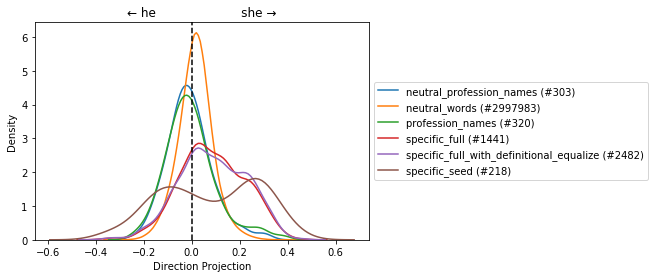

In [12]:
w2v_gender_bias_we.plot_dist_projections_on_direction();

### Generate analogies along the gender direction

<div class="alert alert-warning">
  <strong>Warning!</strong>

The following paper criticize the generating analogies process when used with `unrestricted=False` (as in the original Tolga's paper):

Nissim, M., van Noord, R., van der Goot, R. (2019). [Fair is Better than Sensational: Man is to Doctor as Woman is to Doctor](https://arxiv.org/abs/1905.09866).

Using `unrestricted=False` will prevent the generation of analogies of the form `a:x::b:x` such as `she:doctor::he:doctor`. Therefore, the method my introduce "fake" bias.

`unrestricted` is set to `False` by default.
</div>

In [13]:
w2v_gender_bias_we.generate_analogies(131)[100:]

/project/responsibly/responsibly/we/bias.py:528: UserWarning: Not Using unrestricted most_similar may introduce fake biased analogies.


,she,he,distance,score
100,Michelle,Kris,0.998236,0.278537
101,Marie,Rene,0.964208,0.277007
102,Because,Obviously,0.831023,0.275847
103,Freshman,Rookie,0.860134,0.275070
104,L.,D.,0.547581,0.270656
105,gender,racial,0.929380,0.270301
106,designer,architect,0.998560,0.269882
107,pitcher,starter,0.880994,0.269517
108,dress,garb,0.922170,0.268413
109,midfielder,playmaker,0.794748,0.264263


Let's examine the analogy #129: `she:volleyball::he:football`. We can try to reproduce it with by applying the arithmetic by ourselves: `football - he + she` with *responsibly*'s `most_similar`:

In [14]:
most_similar(w2v_model, positive=['volleyball', 'he'], negative=['she'], topn=3)

[('volleyball', 0.6795172777227771),
 ('football', 0.5900704595582971),
 ('basketball', 0.5792855302799551)]

While *gensim*'s `most_similar` drops results which are in the original equation (i.e. `positives` or `negatives`)

In [15]:
w2v_model.most_similar(positive=['volleyball', 'he'], negative=['she'], topn=3)

[('football', 0.5900704860687256),
 ('basketball', 0.5792855620384216),
 ('soccer', 0.5567079782485962)]

Because of Tolga's method of generating analogies which are used in `generate_analogies`, it is not possible to come up with analogies that have the form `she:X::he:X`, that doesn't reflect a gender bias. Therefore, the method itself may introduce "fake" bias.

We can run `generate_analogies` with `unrestricted=True` to address this issue. Then, for each generated analogies, *responsibly*'s `most_similar` function will be called twice for `she:X::he:Y` - once for getting `X` and second for `Y`. An analogy is considered to be *matched* if the generated `X` and `Y` match the results from `most_similar`.

Note: running with `unrestricted=True` may take some minutes on the original word embedding. Therefore we will use a reduced version of Word2Vec which is available in *responsibly*.

In [16]:
from responsibly.we import load_w2v_small

model_w2v_small = load_w2v_small()
w2v_small_gender_bias_we = GenderBiasWE(model_w2v_small)

In [17]:
w2v_small_gender_bias_we.generate_analogies(50, unrestricted=True)[40:]

,she,he,distance,score,most_x,most_y,match
40,sexy,manly,0.957372,0.315748,manly,sexy,False
41,females,males,0.540050,0.309507,females,males,True
42,pink,red,0.884951,0.307515,red,pink,False
43,wonderful,great,0.685876,0.303149,great,wonderful,False
44,chair,chairman,0.876192,0.300693,chairwoman,chair,False
45,friends,buddies,0.771554,0.299829,buddies,friends,False
46,female,male,0.564742,0.295819,male,female,False
47,beauty,grandeur,0.995714,0.293428,grandeur,beauty,False
48,teenager,youngster,0.726009,0.289508,youngster,teenager,False
49,cute,goofy,0.823867,0.289354,goofy,cute,False


### Generate the Indirect Gender Bias in the direction `softball`-`football`

In [18]:
w2v_gender_bias_we.generate_closest_words_indirect_bias('softball', 'football')

projection  indirect_bias
end      word                                       
softball bookkeeper          0.178528       0.201158
         receptionist        0.158782       0.672343
         registered_nurse    0.156625       0.287150
         waitress            0.145104       0.317842
         paralegal           0.142549       0.372737
football cleric             -0.165978       0.017845
         maestro            -0.180458       0.415805
         pundit             -0.193208       0.101227
         businessman        -0.195981       0.170079
         footballer         -0.337858       0.015366

### Association with percentage of female in occupation

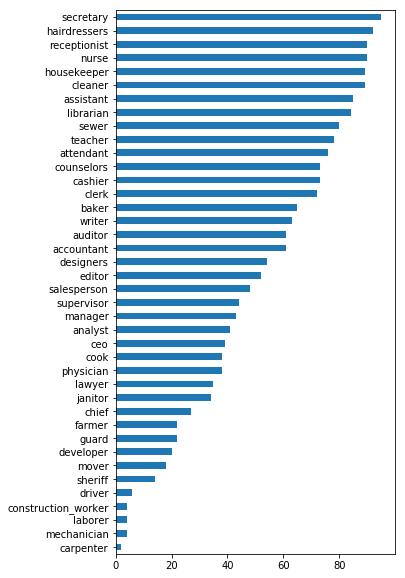

In [19]:
import pandas as pd

from responsibly.we.data import OCCUPATION_FEMALE_PRECENTAGE

pd.Series(OCCUPATION_FEMALE_PRECENTAGE).sort_values().plot(kind='barh', figsize=(5, 10));

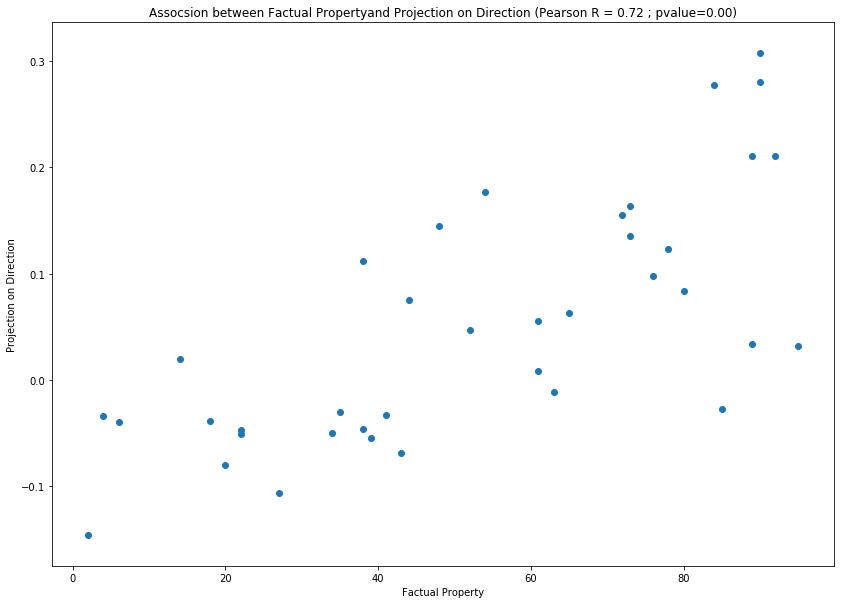

In [20]:
f, ax = plt.subplots(1, figsize=(14, 10))

w2v_gender_bias_we.plot_factual_association(ax=ax);

### Perform hard-debiasing

The table shows the details of the equalize step on the equality sets.

In [21]:
w2v_gender_debias_we = w2v_gender_bias_we.debias('hard', inplace=False)

Neutralize...


100%|████████████████████████████████████████████████████████████████████████| 2997983/2997983 [02:12<00:00, 22549.86it/s]


Equalize...
Equalize Words Data (all equal for 1-dim bias space (direction):
                            equalized_projected_scalar    projected_scalar    scaling
------------------------  ----------------------------  ------------------  ---------
(0, 'twin_brother')                          -0.490669        -0.236034      0.490669
(0, 'twin_sister')                            0.490669         0.335621      0.490669
(1, 'she')                                    0.443113         0.469059      0.443113
(1, 'he')                                    -0.443113        -0.362353      0.443113
(2, 'king')                                  -0.42974         -0.147191      0.42974
(2, 'queen')                                  0.42974          0.349422      0.42974
(3, 'brother')                               -0.379581        -0.215975      0.379581
(3, 'sister')                                 0.379581         0.30764       0.379581
(4, 'SHE')                                    0.540225         0.

## Now our model is gender debiased, let's check what changed...

### Evaluate the debiased model


The evaluation of the word embedding did not change so much because of the debiasing:

In [22]:
w2v_debiased_evaluation = w2v_gender_debias_we.evaluate_word_embedding()

In [23]:
w2v_debiased_evaluation[0]

,pearson_r,pearson_pvalue,spearman_r,spearman_pvalue,ratio_unkonwn_words
MEN,0.680,0.000,0.698,0.00,0.000
Mturk,0.633,0.000,0.657,0.00,0.000
RG65,0.800,0.031,0.685,0.09,0.000
RW,0.522,0.000,0.552,0.00,33.727
SimLex999,0.450,0.000,0.439,0.00,0.100
TR9856,0.660,0.000,0.661,0.00,85.430
WS353,0.621,0.000,0.657,0.00,0.000


In [24]:
w2v_debiased_evaluation[1]

,score
Google,0.737
MSR-syntax,0.737


### Calculate direct gender bias

In [25]:
w2v_gender_debias_we.calc_direct_bias()

1.2674784842026455e-09

The word embedding is not biased any more (in the professions sense).

### Plot the projection of the most extreme professions on the gender direction
Note that (almost) all of the non-zero projection words are gender specific.

The word *teenager* have a projection on the gender direction because it was learned mistakenly as a gender-specific word by the linear SVM, and thus it was not neutralized in the debias processes.

The words provost, serviceman and librarian have zero projection on the gender direction.

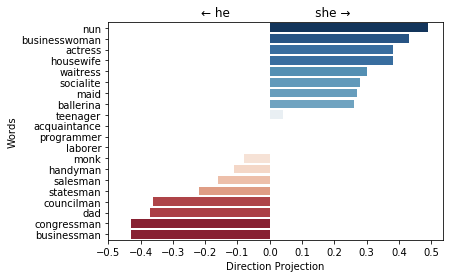

In [26]:
w2v_gender_debias_we.plot_projection_scores();

### Generate analogies along the gender direction

In [27]:
w2v_gender_debias_we.generate_analogies(150)[50:]

/project/responsibly/responsibly/we/bias.py:528: UserWarning: Not Using unrestricted most_similar may introduce fake biased analogies.


,she,he,distance,score
50,teenagers,males,0.993710,3.133955e-01
51,horses,colt,0.888134,3.126180e-01
52,cousin,younger_brother,0.758962,3.097599e-01
53,really,guys,0.904382,2.780662e-01
54,Lady,Girl,0.981106,2.474099e-01
55,son,Uncle,0.948682,2.285694e-01
56,mum,daddy,0.980105,2.232467e-01
57,Boy,Guy,0.917343,2.170350e-01
58,lady,waitress,0.972788,2.142569e-01
59,boy,gentleman,0.988562,2.129009e-01


### Generate the Indirect Gender Bias in the direction `softball`-`football`

In [28]:
w2v_gender_debias_we.generate_closest_words_indirect_bias('softball', 'football')

projection  indirect_bias
end      word                                      
softball infielder          0.149894   1.517707e-07
         major_leaguer      0.113700   2.272566e-07
         bookkeeper         0.104209   6.543536e-08
         patrolman          0.092638   8.575430e-08
         investigator       0.081746  -1.304292e-08
football midfielder        -0.153175  -6.718459e-08
         lecturer          -0.153629   5.327011e-08
         vice_chancellor   -0.159645  -2.232139e-08
         cleric            -0.166934  -1.153845e-08
         footballer        -0.325018   6.779356e-08

### Now Let's Try with fastText

In [29]:
fasttext_gender_bias_we = GenderBiasWE(fasttext_model, only_lower=False, verbose=True)

Identify direction using pca method...
  Principal Component    Explained Variance Ratio
---------------------  --------------------------
                    1                   0.531331
                    2                   0.18376
                    3                   0.089777
                    4                   0.0517856
                    5                   0.0407739
                    6                   0.0328988
                    7                   0.0223339
                    8                   0.0193495
                    9                   0.0143259
                   10                   0.0136648


### We can compare the projections of neutral profession names on the gender direction for the two original word embeddings

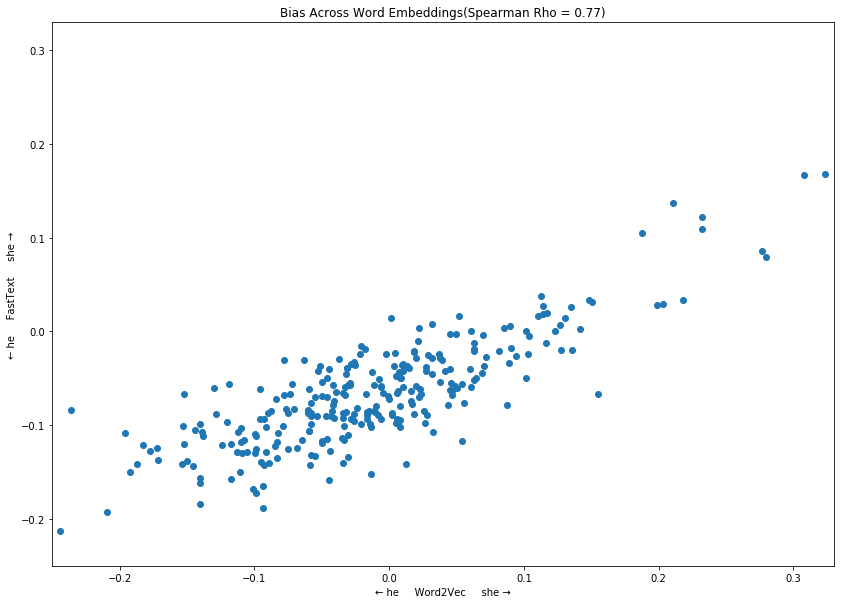

In [30]:
f, ax = plt.subplots(1, figsize=(14, 10))
GenderBiasWE.plot_bias_across_word_embeddings({'Word2Vec': w2v_gender_bias_we,
                                               'FastText': fasttext_gender_bias_we},
                                              ax=ax)

### Can we identify race bias? (Exploratory - API may change in a future release)

In [31]:
from responsibly.we import BiasWordEmbedding
from responsibly.we.data import BOLUKBASI_DATA

In [32]:
white_common_names = ['Emily', 'Anne', 'Jill', 'Allison', 'Laurie', 'Sarah', 'Meredith', 'Carrie',
                      'Kristen', 'Todd', 'Neil', 'Geoffrey', 'Brett', 'Brendan', 'Greg', 'Matthew',
                      'Jay', 'Brad']

black_common_names = ['Aisha', 'Keisha', 'Tamika', 'Lakisha', 'Tanisha', 'Latoya', 'Kenya', 'Latonya',
                      'Ebony', 'Rasheed', 'Tremayne', 'Kareem', 'Darnell', 'Tyrone', 'Hakim', 'Jamal',
                      'Leroy', 'Jermaine']

In [33]:
race_bias_we = BiasWordEmbedding(w2v_model,
                                 verbose=True)

In [34]:
race_bias_we._identify_direction('Whites', 'Blacks',
                                 definitional=(white_common_names, black_common_names),
                                 method='sum')

Identify direction using sum method...


In [35]:
neutral_profession_names = race_bias_we._filter_words_by_model(BOLUKBASI_DATA['gender']['neutral_profession_names'])

In [36]:
race_bias_we.calc_direct_bias(neutral_profession_names)

0.0570313461966939

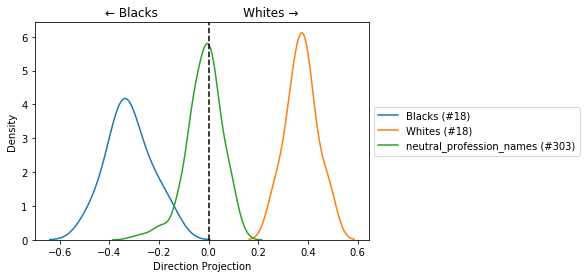

In [37]:
race_bias_we.plot_dist_projections_on_direction({'neutral_profession_names': neutral_profession_names,
                                                 'Whites': white_common_names,
                                                 'Blacks': black_common_names});

In [38]:
race_bias_we.generate_analogies(30)

/project/responsibly/responsibly/we/bias.py:528: UserWarning: Not Using unrestricted most_similar may introduce fake biased analogies.


,Whites,Blacks,distance,score
0,white,blacks,0.984017,0.300863
1,central_bank,Federal_Reserve,0.803605,0.288356
2,Everton,Merseyside,0.977917,0.267331
3,Reds,Marlins,0.913352,0.265320
4,Palmer,Lewis,0.963303,0.257839
5,Chapman,Goodman,0.922701,0.257333
6,World_Cup,Olympics,0.908482,0.255429
7,want,Why,0.981551,0.251682
8,virus,HIV,0.948869,0.250508
9,usually,Often,0.904155,0.237194


In [39]:
race_bias_we.generate_analogies(130)[100:]

/project/responsibly/responsibly/we/bias.py:528: UserWarning: Not Using unrestricted most_similar may introduce fake biased analogies.


,Whites,Blacks,distance,score
100,only,Only,0.943405,0.197555
101,Fletcher,Norris,0.947846,0.197228
102,red,white,0.928751,0.196619
103,jurors,Jurors,0.697708,0.196573
104,complaints,Complaints,0.710755,0.196412
105,knee_injury,ankle_sprain,0.631131,0.196400
106,automatic,automated,0.955530,0.196397
107,worries,Concerns,0.794042,0.196306
108,Player,Athlete,0.867647,0.196244
109,cricket,BCCI,0.885252,0.196228


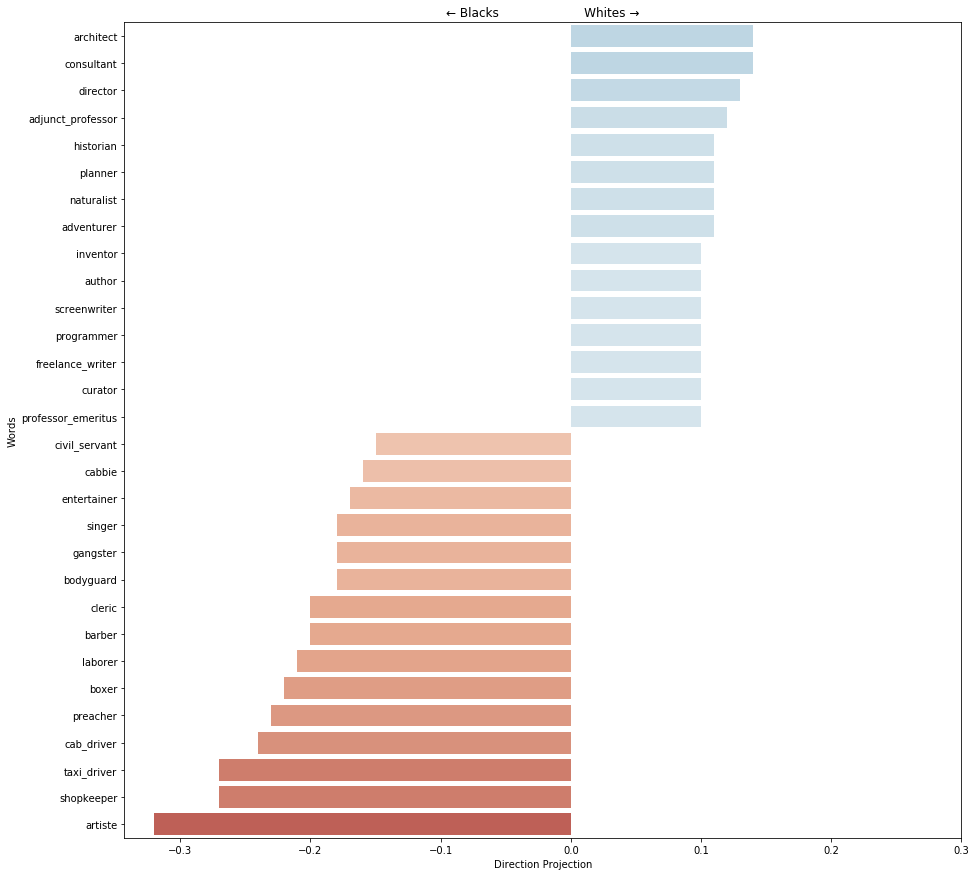

In [40]:
f, ax = plt.subplots(figsize=(15, 15))
race_bias_we.plot_projection_scores(neutral_profession_names, 15, ax=ax);

## Word Embedding Association Test (WEAT)

Based on: Caliskan, A., Bryson, J. J., & Narayanan, A. (2017). [Semantics derived automatically from language corpora contain human-like biases](http://www.cs.bath.ac.uk/~jjb/ftp/CaliskanEtAl-authors-full.pdf). Science, 356(6334), 183-186.

In [41]:
from responsibly.we import calc_all_weat

### First, let's look on a reduced version of Word2Vec.

In [42]:
calc_all_weat(model_w2v_small, filter_by='model', with_original_finding=True,
              with_pvalue=True, pvalue_kwargs={'method': 'approximate'})

/project/responsibly/responsibly/we/weat.py:368: UserWarning: Given weat_data was filterd by model.


,Target words,Attrib. words,Nt,Na,s,d,p,original_N,original_d,original_p
0,Flowers vs. Insects,Pleasant vs. Unpleasant,2x2,24x2,0.0455987,1.2461,1.6e-01,32,1.35,1e-8
1,Instruments vs. Weapons,Pleasant vs. Unpleasant,16x2,24x2,0.9667,1.59092,0,32,1.66,1e-10
2,European American names vs. African American n...,Pleasant vs. Unpleasant,6x2,24x2,0.136516,1.1408,2.3e-02,26,1.17,1e-5
3,European American names vs. African American n...,Pleasant vs. Unpleasant,18x2,24x2,0.440816,1.3369,0,,,
4,European American names vs. African American n...,Pleasant vs. Unpleasant,18x2,8x2,0.33806,0.733674,1.8e-02,,,
5,Male names vs. Female names,Career vs. Family,1x2,8x2,0.154198,2,0,39k,0.72,< 1e-2
6,Math vs. Arts,Male terms vs. Female terms,7x2,8x2,0.161991,0.835966,5.8e-02,28k,0.82,< 1e-2
7,Science vs. Arts,Male terms vs. Female terms,6x2,8x2,0.303524,1.37307,7.0e-03,91,1.47,1e-24
8,Mental disease vs. Physical disease,Temporary vs. Permanent,6x2,5x2,0.342582,1.18702,2.5e-02,135,1.01,1e-3
9,Young people’s names vs. Old people’s names,Pleasant vs. Unpleasant,0x2,7x2,,,,43k,1.42,< 1e-2


### Let's reproduce the results from the paper on the full Word2Vec and Glove word embeddings:

In [43]:
calc_all_weat(glove_model, filter_by='data', with_original_finding=True,
              with_pvalue=True, pvalue_kwargs={'method': 'approximate'})

/project/responsibly/responsibly/we/weat.py:368: UserWarning: Given weat_data was filterd by data.


,Target words,Attrib. words,Nt,Na,s,d,p,original_N,original_d,original_p
0,Flowers vs. Insects,Pleasant vs. Unpleasant,25x2,25x2,2.2382,1.5196,0,32,1.35,1e-8
1,Instruments vs. Weapons,Pleasant vs. Unpleasant,25x2,25x2,2.2906,1.5496,0,32,1.66,1e-10
2,European American names vs. African American n...,Pleasant vs. Unpleasant,32x2,25x2,1.6208,1.4163,0,26,1.17,1e-5
3,European American names vs. African American n...,Pleasant vs. Unpleasant,16x2,25x2,0.7272,1.5226,0,,,
4,European American names vs. African American n...,Pleasant vs. Unpleasant,16x2,8x2,0.9177,1.3045,0,,,
5,Male names vs. Female names,Career vs. Family,8x2,8x2,1.2670,1.8734,0,39k,0.72,< 1e-2
6,Math vs. Arts,Male terms vs. Female terms,8x2,8x2,0.1989,1.0896,1.6e-02,28k,0.82,< 1e-2
7,Science vs. Arts,Male terms vs. Female terms,8x2,8x2,0.3456,1.2780,2.0e-03,91,1.47,1e-24
8,Mental disease vs. Physical disease,Temporary vs. Permanent,6x2,7x2,0.5051,1.4442,2.0e-03,135,1.01,1e-3
9,Young people’s names vs. Old people’s names,Pleasant vs. Unpleasant,8x2,8x2,0.5096,1.5520,0,43k,1.42,< 1e-2


### Results from the paper:

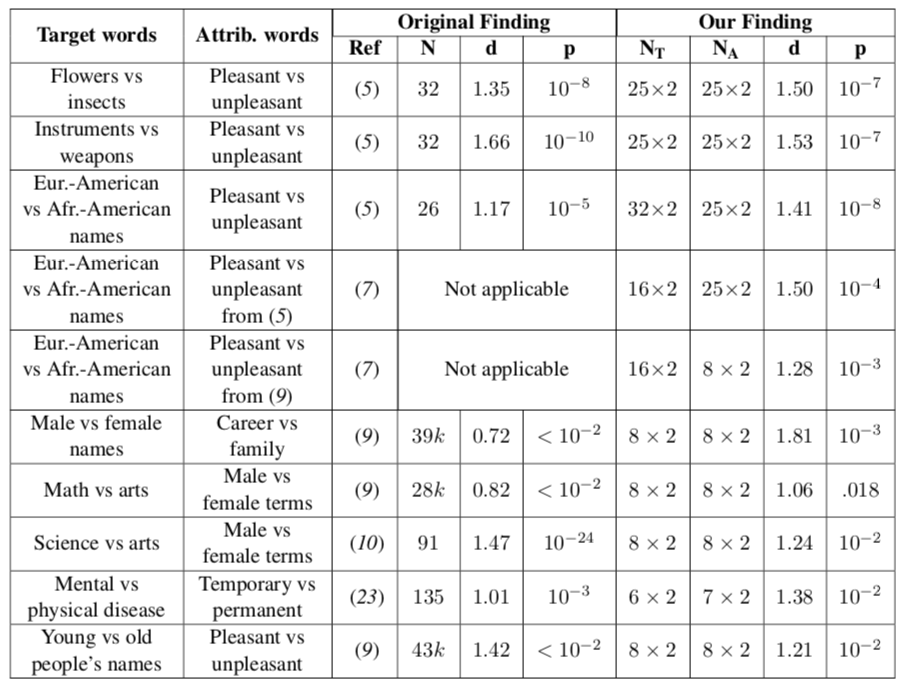

In [44]:
calc_all_weat(w2v_model, filter_by='model', with_original_finding=True,
              with_pvalue=True, pvalue_kwargs={'method': 'approximate'})

/project/responsibly/responsibly/we/weat.py:368: UserWarning: Given weat_data was filterd by model.


,Target words,Attrib. words,Nt,Na,s,d,p,original_N,original_d,original_p
0,Flowers vs. Insects,Pleasant vs. Unpleasant,25x2,25x2,1.4078,1.5550,0,32,1.35,1e-8
1,Instruments vs. Weapons,Pleasant vs. Unpleasant,24x2,25x2,1.7317,1.6638,0,32,1.66,1e-10
2,European American names vs. African American n...,Pleasant vs. Unpleasant,47x2,25x2,0.5672,0.6047,1.0e-03,26,1.17,1e-5
3,European American names vs. African American n...,Pleasant vs. Unpleasant,18x2,25x2,0.4180,1.3320,0,,,
4,European American names vs. African American n...,Pleasant vs. Unpleasant,18x2,8x2,0.3381,0.7337,1.8e-02,,,
5,Male names vs. Female names,Career vs. Family,8x2,8x2,1.2516,1.9518,0,39k,0.72,< 1e-2
6,Math vs. Arts,Male terms vs. Female terms,8x2,8x2,0.2255,0.9981,2.7e-02,28k,0.82,< 1e-2
7,Science vs. Arts,Male terms vs. Female terms,8x2,8x2,0.3572,1.2846,0,91,1.47,1e-24
8,Mental disease vs. Physical disease,Temporary vs. Permanent,6x2,6x2,0.3727,1.3259,1.3e-02,135,1.01,1e-3
9,Young people’s names vs. Old people’s names,Pleasant vs. Unpleasant,8x2,7x2,-0.0852,-0.3721,7.4e-01,43k,1.42,< 1e-2


### Results from the paper:

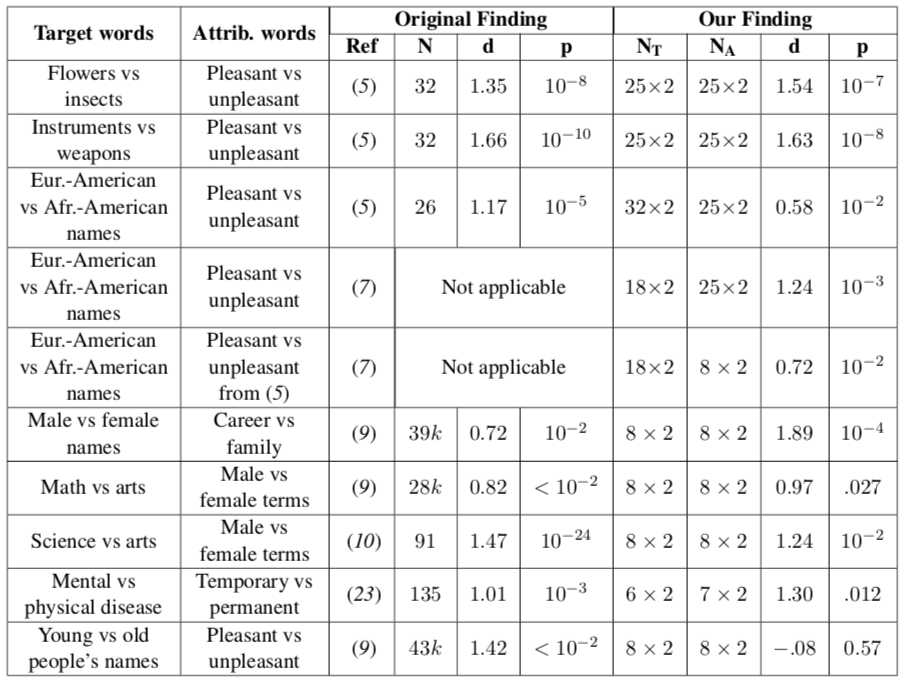

### It is possible also to expirements with new target word sets as in this example (Citizen-Immigrant)

No WEAT bias in this case.

In [45]:
from responsibly.we import calc_weat_pleasant_unpleasant_attribute

targets = {'first_target': {'name': 'Citizen',
                            'words': ['citizen', 'citizenship', 'nationality', 'native', 'national', 'countryman', 
                                      'inhabitant', 'resident']},
          'second_target': {'name': 'Immigrant',
                            'words': ['immigrant', 'immigration', 'foreigner', 'nonnative', 'noncitizen',
                                      'relocatee', 'newcomer']}}

calc_weat_pleasant_unpleasant_attribute(w2v_model, **targets)

{'Attrib. words': 'Pleasant vs. Unpleasant',
 'Na': '25x2',
 'Nt': '6x2',
 'Target words': 'Citizen vs. Immigrant',
 'd': 0.70259565,
 'p': 0.13852813852813853,
 's': 0.1026485487818718}

## Did Tolga's hard debias method actually remove the gender bias?



<div class="alert alert-warning">
  <strong>Warning!</strong>
The following paper suggests that the current methods have an only superficial effect on the bias in word embeddings:

Gonen, H., & Goldberg, Y. (2019). [Lipstick on a Pig:
Debiasing Methods Cover up Systematic Gender Biases
in Word Embeddings But do not Remove Them](https://arxiv.org/abs/1903.03862).
arXiv preprint arXiv:1903.03862.
</div>

Note: the numbers are not exactly as in the paper due to a slightly different preprocessing of the word embedding.

### First experiment - WEAT before and after debias

In [46]:
# before

calc_all_weat(w2v_gender_bias_we.model, weat_data=(5, 6, 7),
              filter_by='model', with_original_finding=True,
              with_pvalue=True)

/project/responsibly/responsibly/we/weat.py:368: UserWarning: Given weat_data was filterd by model.


,Target words,Attrib. words,Nt,Na,s,d,p,original_N,original_d,original_p
0,Male names vs. Female names,Career vs. Family,8x2,8x2,1.2516,1.9518,0,39k,0.72,< 1e-2
1,Math vs. Arts,Male terms vs. Female terms,8x2,8x2,0.2255,0.9981,2.3e-02,28k,0.82,< 1e-2
2,Science vs. Arts,Male terms vs. Female terms,8x2,8x2,0.3572,1.2846,4.0e-03,91,1.47,1e-24


In [47]:
# after

calc_all_weat(w2v_gender_debias_we.model, weat_data=(5, 6, 7),
              filter_by='model', with_original_finding=True,
              with_pvalue=True)

/project/responsibly/responsibly/we/weat.py:368: UserWarning: Given weat_data was filterd by model.


,Target words,Attrib. words,Nt,Na,s,d,p,original_N,original_d,original_p
0,Male names vs. Female names,Career vs. Family,8x2,8x2,0.7067,1.7923,0,39k,0.72,< 1e-2
1,Math vs. Arts,Male terms vs. Female terms,8x2,8x2,-0.0618,-1.1726,1.0e+00,28k,0.82,< 1e-2
2,Science vs. Arts,Male terms vs. Female terms,8x2,8x2,-0.0286,-0.5306,8.4e-01,91,1.47,1e-24


For the first experiment, the WEAT score is still significant, while not for the other two. As stated in Gonen et al. paper, this is because the specific gender words as an attribute in the second and the third experiment are handled by the debiasing method.

Let's use the target words of the first experiment (Male names vs. Female names) with the target words of the other two experiments as attribute words (Math vs. Arts and Science vs. Arts).

In [48]:
from responsibly.we import calc_single_weat
from responsibly.we.data import WEAT_DATA

In [49]:
# Significant result

calc_single_weat(w2v_gender_debias_we.model,
                 WEAT_DATA[5]['first_target'],
                 WEAT_DATA[5]['second_target'],
                 WEAT_DATA[6]['first_target'],
                 WEAT_DATA[6]['second_target'])

{'Attrib. words': 'Math vs. Arts',
 'Na': '8x2',
 'Nt': '8x2',
 'Target words': 'Male names vs. Female names',
 'd': 1.513799,
 'p': 0.0009324009324009324,
 's': 0.34435559436678886}

In [50]:
# Significant result

calc_single_weat(w2v_gender_debias_we.model,
                 WEAT_DATA[5]['first_target'],
                 WEAT_DATA[5]['second_target'],
                 WEAT_DATA[7]['first_target'],
                 WEAT_DATA[7]['second_target'])

{'Attrib. words': 'Science vs. Arts',
 'Na': '8x2',
 'Nt': '8x2',
 'Target words': 'Male names vs. Female names',
 'd': 1.0226882,
 'p': 0.022455322455322457,
 's': 0.20674265176057816}

### Second experiment - Clustering as classification of the most biased neutral words

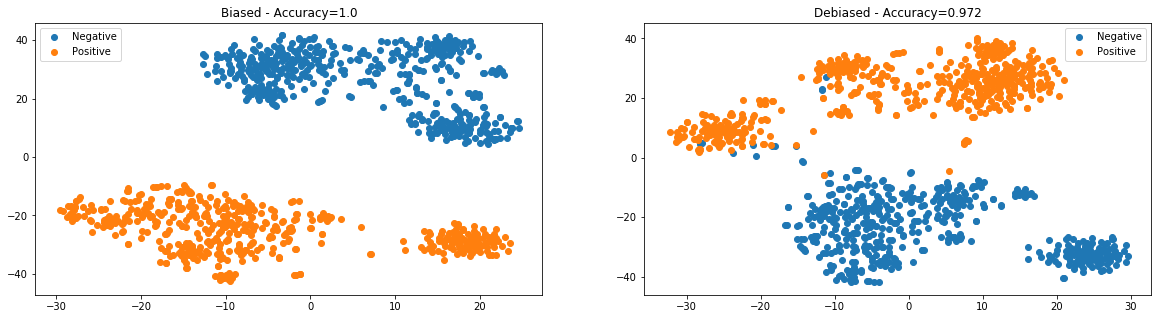

In [51]:
GenderBiasWE.plot_most_biased_clustering(w2v_gender_bias_we, w2v_gender_debias_we);